In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- Database Connection ---

# Let's print the current working directory to be 100% sure where we are
cwd = os.getcwd()
print(f"Jupyter's Current Working Directory is: {cwd}")

# Based on this, we construct the path. The notebook is in 'python', DB is in 'sql'.
# The path should be relative from the CWD.
# If CWD is '.../adtm/python', then '../sql/adtm.db' is correct.
# If CWD is '.../adtm', then 'sql/adtm.db' is correct.

DATABASE_PATH = 'sql/adtm.db' # Try this path first, assuming CWD is the project root 'adtm'

if not os.path.exists(DATABASE_PATH):
    # If that fails, try the other common path
    DATABASE_PATH = '../sql/adtm.db' # Assumes CWD is the 'python' subfolder

# Now, check if we found it with either path
if not os.path.exists(DATABASE_PATH):
    print("\n--- ERROR ---")
    print(f"Could not find the database file.")
    print(f"We checked for 'sql/adtm.db' and '../sql/adtm.db' relative to the CWD.")
    print("Please ensure you launched jupyter-lab from your project's root 'adtm' directory.")

else:
    print(f"\nFound database file at relative path: '{DATABASE_PATH}'")
    print(f"The absolute path is: {os.path.abspath(DATABASE_PATH)}")
    print("Connecting to the database...")
    conn = sqlite3.connect(DATABASE_PATH)
    print("Connection successful!")

Jupyter's Current Working Directory is: C:\Users\fedra\OneDrive\Desktop\adtm

Found database file at relative path: 'sql/adtm.db'
The absolute path is: C:\Users\fedra\OneDrive\Desktop\adtm\sql\adtm.db
Connecting to the database...
Connection successful!


In [3]:
print("Loading data from database...")

# Load the main filings and scores data, joining them together
main_query = """
SELECT
    f.filing_id,
    f.ticker,
    f.form_type,
    f.filing_date,
    f.word_count,
    s.T_score,
    s.R_score,
    s.A_score,
    s.RAI_score
FROM filings f
JOIN scores s ON f.filing_id = s.filing_id;
"""
df = pd.read_sql_query(main_query, conn)

# Load the detailed term counts for deeper analysis
counts_query = """
SELECT 
    c.filing_id,
    t.term, 
    t.category, 
    c.section, 
    c.frequency
FROM counts c
JOIN terms t ON c.term_id = t.term_id;
"""
df_counts = pd.read_sql_query(counts_query, conn)

# Load snippets for qualitative validation
snippets_query = """
SELECT
    s.filing_id,
    t.term,
    s.context
FROM snippets s
JOIN terms t ON s.term_id = t.term_id;
"""
df_snippets = pd.read_sql_query(snippets_query, conn)


# --- Data Preparation ---
# Convert filing_date to datetime objects for time series analysis
df['filing_date'] = pd.to_datetime(df['filing_date'])
df['year'] = df['filing_date'].dt.year

print("Data loaded successfully!")
print(f"Loaded {len(df)} filings, {len(df_counts)} term counts, and {len(df_snippets)} snippets.")

Loading data from database...
Data loaded successfully!
Loaded 100 filings, 465 term counts, and 3245 snippets.


In [5]:
print("--- Main Data Overview ---")
df.info()
print("\n\n--- Descriptive Statistics for Scores ---")
# Using .describe() to get key stats like mean, std, min, max, etc.
print(df[['T_score', 'R_score', 'A_score', 'RAI_score']].describe())

--- Main Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   filing_id    100 non-null    int64         
 1   ticker       100 non-null    object        
 2   form_type    100 non-null    object        
 3   filing_date  100 non-null    datetime64[ns]
 4   word_count   100 non-null    int64         
 5   T_score      100 non-null    float64       
 6   R_score      100 non-null    float64       
 7   A_score      100 non-null    float64       
 8   RAI_score    100 non-null    float64       
 9   year         100 non-null    int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2), object(2)
memory usage: 7.6+ KB


--- Descriptive Statistics for Scores ---
          T_score  R_score     A_score   RAI_score
count  100.000000    100.0  100.000000  100.000000
mean     0.023689      0.0    0.001553    0.

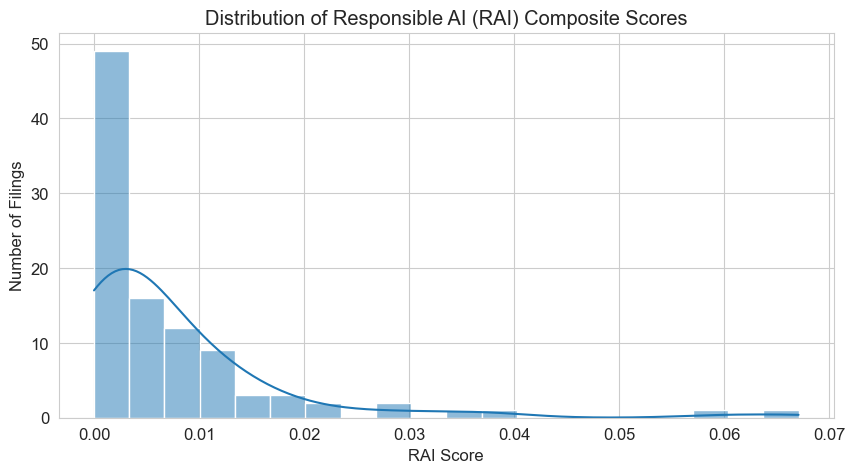

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df['RAI_score'], bins=20, kde=True)
plt.title('Distribution of Responsible AI (RAI) Composite Scores')
plt.xlabel('RAI Score')
plt.ylabel('Number of Filings')
plt.show()

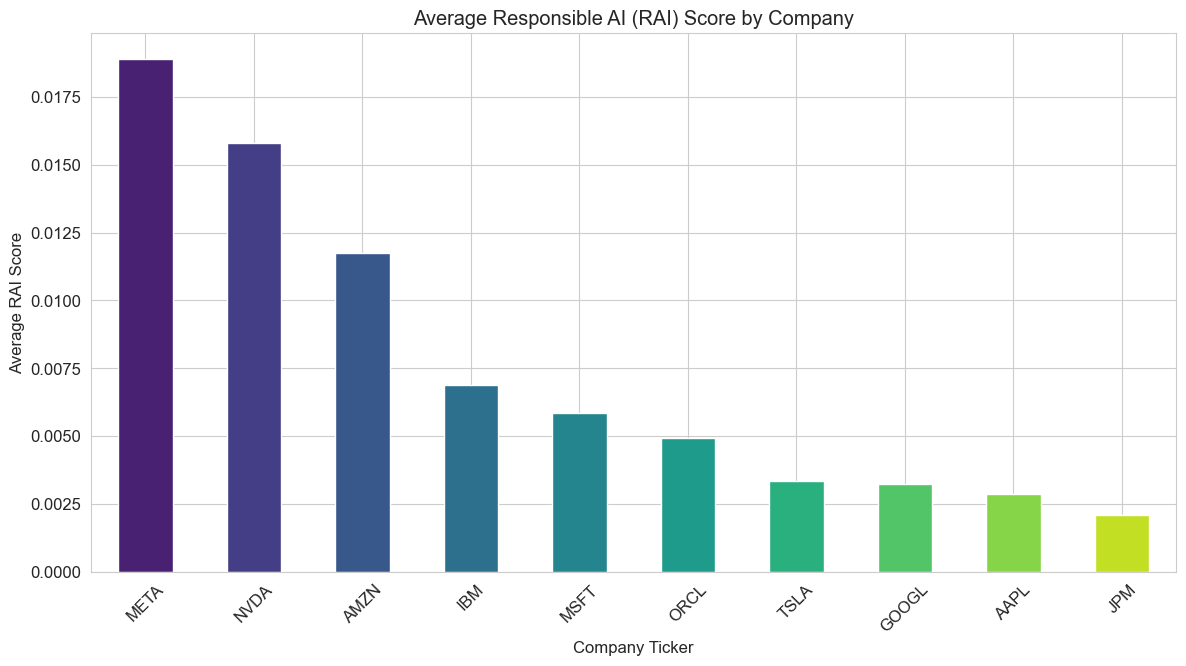

In [8]:
# Calculate the average RAI score for each company
avg_scores_by_company = df.groupby('ticker')['RAI_score'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
avg_scores_by_company.plot(kind='bar', color=sns.color_palette("viridis", len(avg_scores_by_company)))
plt.title('Average Responsible AI (RAI) Score by Company')
plt.xlabel('Company Ticker')
plt.ylabel('Average RAI Score')
plt.xticks(rotation=45)
plt.show()

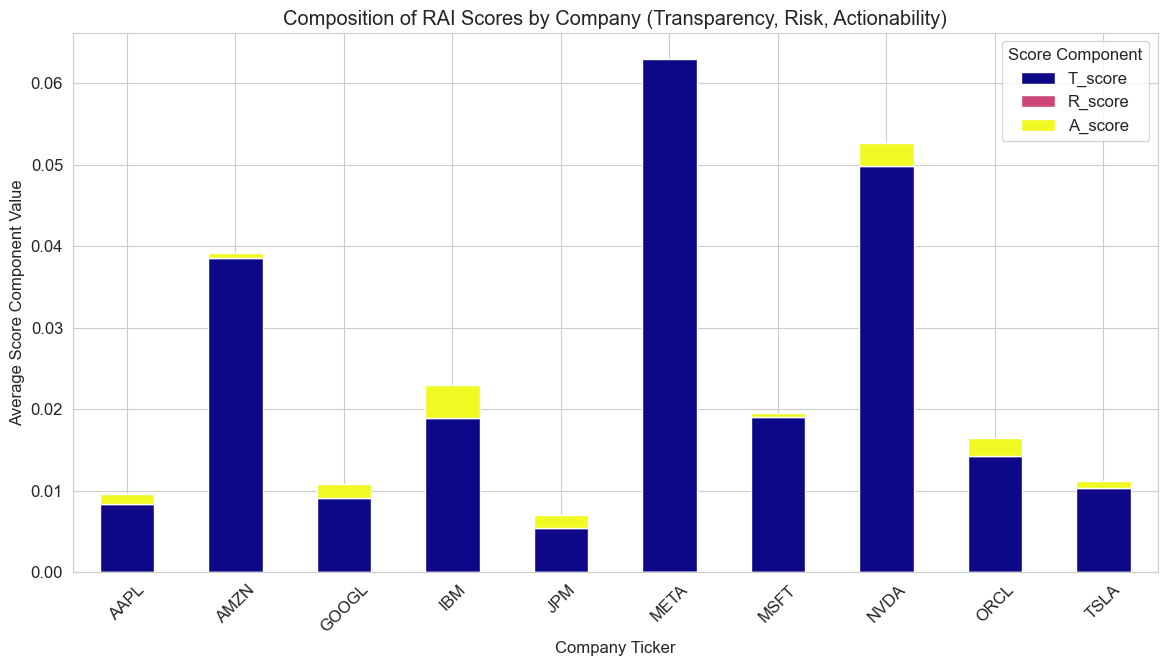

In [9]:
# Calculate the average of each score component (T, R, A) for each company
score_composition = df.groupby('ticker')[['T_score', 'R_score', 'A_score']].mean()
# Plot a stacked bar chart to show the composition
score_composition.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='plasma')
plt.title('Composition of RAI Scores by Company (Transparency, Risk, Actionability)')
plt.xlabel('Company Ticker')
plt.ylabel('Average Score Component Value')
plt.xticks(rotation=45)
plt.legend(title='Score Component')
plt.show()

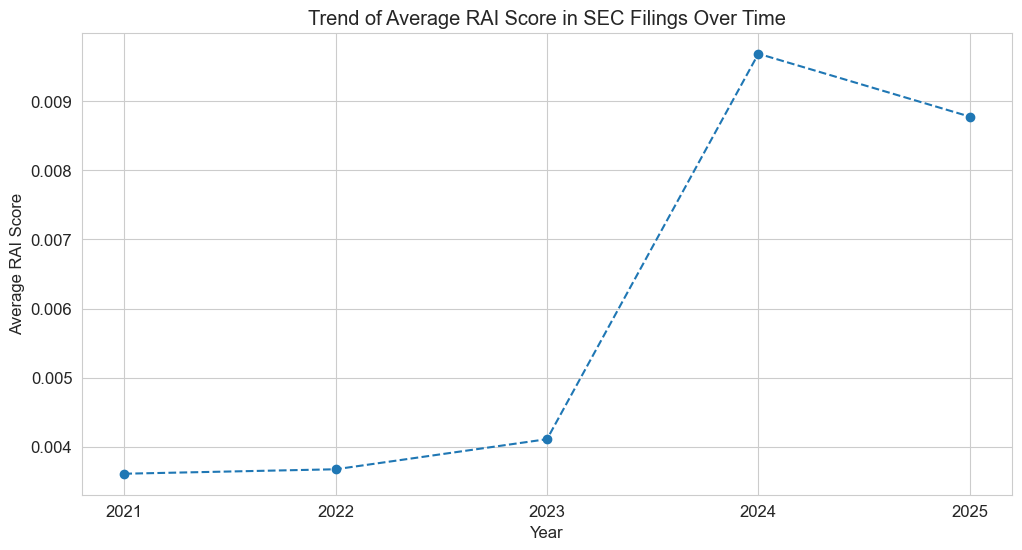

In [12]:
# Calculate the average RAI score per year
avg_score_by_year = df.groupby('year')['RAI_score'].mean()
plt.figure(figsize=(12, 6))
avg_score_by_year.plot(kind='line', marker='o', linestyle='--')
plt.title('Trend of Average RAI Score in SEC Filings Over Time')
plt.xlabel('Year')
plt.ylabel('Average RAI Score')
plt.xticks(avg_score_by_year.index.astype(int)) # Ensure integer years on x-axis
plt.grid(True)
plt.show()

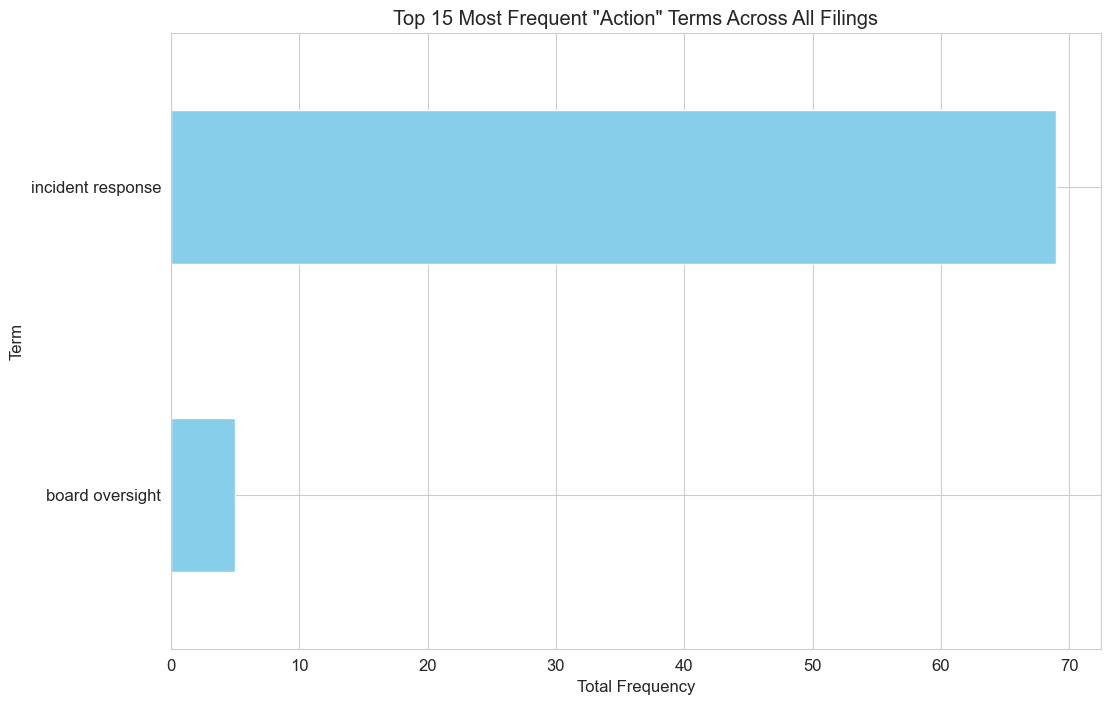

In [13]:
# Merge counts with the main dataframe to get ticker and year info
df_counts_merged = pd.merge(df_counts, df[['filing_id', 'ticker']], on='filing_id')
# Top 15 most frequent "Action" terms
top_action_terms = df_counts_merged[df_counts_merged['category'] == 'action'].groupby('term')['frequency'].sum().nlargest(15)
plt.figure(figsize=(12, 8))
top_action_terms.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 15 Most Frequent "Action" Terms Across All Filings')
plt.xlabel('Total Frequency')
plt.ylabel('Term')
plt.show()

In [14]:
# Find the filing with the HIGHEST RAI score
highest_score_filing = df.loc[df['RAI_score'].idxmax()]
highest_filing_id = highest_score_filing['filing_id']

print("--- VALIDATION: HIGHEST SCORING FILING ---")
print(highest_score_filing)

print("\n--- Sample Snippets that contributed to this high score: ---")
snippets_for_high_score = df_snippets[df_snippets['filing_id'] == highest_filing_id]
for i, row in snippets_for_high_score.head(3).iterrows():
    print(f"\nTerm: '{row['term']}'")
    # Wrap text for better readability
    import textwrap
    print(textwrap.fill(row['context'], width=100))
    

# Find the filing with the LOWEST (non-zero) RAI score for contrast
lowest_score_filing = df[df['RAI_score'] > 0].loc[df[df['RAI_score'] > 0]['RAI_score'].idxmin()]
lowest_filing_id = lowest_score_filing['filing_id']

print("--- VALIDATION: LOWEST SCORING (NON-ZERO) FILING ---")
print(lowest_score_filing)

print("\n--- Sample Snippets from this low-scoring filing: ---")
snippets_for_low_score = df_snippets[df_snippets['filing_id'] == lowest_filing_id]
for i, row in snippets_for_low_score.head(3).iterrows():
    print(f"\nTerm: '{row['term']}'")
    print(textwrap.fill(row['context'], width=100))

--- VALIDATION: HIGHEST SCORING FILING ---
filing_id                       75
ticker                        NVDA
form_type                     10-K
filing_date    2025-02-26 00:00:00
word_count                  125230
T_score                   0.199633
R_score                        0.0
A_score                   0.023956
RAI_score                 0.067077
year                          2025
Name: 74, dtype: object

--- Sample Snippets that contributed to this high score: ---

Term: 'artificial intelligence'
...tware development kits, or SDKs, and Application Programming Interfaces, or APIs. This deep and
broad software stack accelerates the performance and eases the deployment of NVIDIA accelerated
computing for computationally intensive workloads such as artificial intelligence, or AI, model
training and inference, data analytics, scientific computing, and 3D graphics, with vertical-
specific optimizations to address industries ranging from healthcare and telecom to automotive and
manu